# MNIST convolutional network

In this example we will show how to build and train
a convolutional network in NengoDL,
and then deploy that network on Loihi.

We'll use the basic MNIST dataset to demonstrate the steps.
The input data are images of handwritten digits,
and the goal is for the network to classify each image as 0-9.

We will assume here that the reader is somewhat familiar with NengoDL,
and focus on the issue of how to use NengoDL to train a network for Loihi.
For a more basic introduction to NengoDL, check out
[the documentation](https://www.nengo.ai/nengo-dl)
and [examples](https://www.nengo.ai/nengo-dl/examples).

In [1]:
%matplotlib inline

import os

import nengo
import nengo_dl
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

try:
    import requests

    has_requests = True
except ImportError:
    has_requests = False

import nengo_loihi

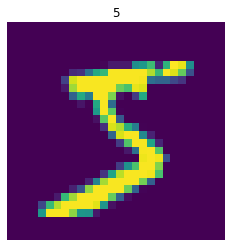

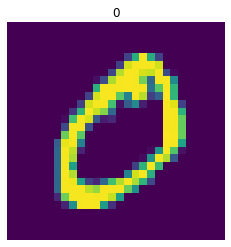

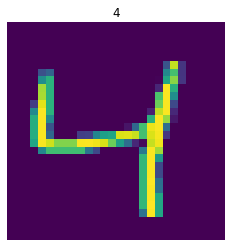

In [2]:
# helper function for later
def download(fname, drive_id):
    """Download a file from Google Drive.

    Adapted from https://stackoverflow.com/a/39225039/1306923
    """

    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith("download_warning"):
                return value
        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)

    if os.path.exists(fname):
        return
    if not has_requests:
        link = "https://drive.google.com/open?id=%s" % drive_id
        raise RuntimeError(
            "Cannot find '%s'. Download the file from\n  %s\n"
            "and place it in %s." % (fname, link, os.getcwd())
        )

    url = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(url, params={"id": drive_id}, stream=True)
    token = get_confirm_token(response)
    if token is not None:
        params = {"id": drive_id, "confirm": token}
        response = session.get(url, params=params, stream=True)
    save_response_content(response, fname)


# load mnist dataset
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

# plot some examples
for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_images[i], (28, 28)))
    plt.axis("off")
    plt.title(str(train_labels[i]))

We'll begin by defining a simple function to build a "convolutional layer".
This is just a `nengo.Connection` and `nengo.Ensemble` put together,
but we'll be doing this a lot so we'll use this function
to put them together in an easy-to-use bundle.

In [3]:
def conv_layer(x, *args, activation=True, **kwargs):
    # create a Conv2D transform with the given arguments
    conv = nengo.Convolution(*args, channels_last=False, **kwargs)

    if activation:
        # add an ensemble to implement the activation function
        layer = nengo.Ensemble(conv.output_shape.size, 1).neurons
    else:
        # no nonlinearity, so we just use a node
        layer = nengo.Node(size_in=conv.output_shape.size)

    # connect up the input object to the new layer
    nengo.Connection(x, layer, transform=conv)

    # print out the shape information for our new layer
    print("LAYER")
    print(conv.input_shape.shape, "->", conv.output_shape.shape)

    return layer, conv

Next we define the structure of our network.
Because we need to keep the number of neurons and axons per core
below the Loihi hardware limits,
we adopt a somewhat unusual network architecture.
We'll have a relatively small core network,
so that each layer fits on one Loihi core,
and then repeat that network several times in parallel, summing their output.
We can think of this as a variation on [ensemble learning
](https://en.wikipedia.org/wiki/Ensemble_averaging_(machine_learning)).
See the [CIFAR-10
example](https://www.nengo.ai/nengo-loihi/examples/cifar10-convnet.html)
for a different approach that uses NengoLoihi's BlockShape functionality
to automatically split larger layers across cores.

In [4]:
dt = 0.001  # simulation timestep
presentation_time = 0.1  # input presentation time
max_rate = 100  # neuron firing rates
# neuron spike amplitude (scaled so that the overall output is ~1)
amp = 1 / max_rate
# input image shape
input_shape = (1, 28, 28)
n_parallel = 2  # number of parallel network repetitions

with nengo.Network(seed=0) as net:
    # set up the default parameters for ensembles/connections
    nengo_loihi.add_params(net)
    net.config[nengo.Ensemble].neuron_type = nengo.SpikingRectifiedLinear(amplitude=amp)
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([max_rate])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    # the input node that will be used to feed in input images
    inp = nengo.Node(
        nengo.processes.PresentInput(test_images, presentation_time), size_out=28 * 28
    )

    # the output node provides the 10-dimensional classification
    out = nengo.Node(size_in=10)

    # build parallel copies of the network
    for _ in range(n_parallel):
        layer, conv = conv_layer(
            inp, 1, input_shape, kernel_size=(1, 1), init=np.ones((1, 1, 1, 1))
        )
        # first layer is off-chip to translate the images into spikes
        net.config[layer.ensemble].on_chip = False
        layer, conv = conv_layer(layer, 6, conv.output_shape, strides=(2, 2))
        layer, conv = conv_layer(layer, 24, conv.output_shape, strides=(2, 2))
        nengo.Connection(layer, out, transform=nengo_dl.dists.Glorot())

    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=nengo.Alpha(0.01), label="out_p_filt")

LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (24, 6, 6)
LAYER
(1, 28, 28) -> (1, 28, 28)
LAYER
(1, 28, 28) -> (6, 13, 13)
LAYER
(6, 13, 13) -> (24, 6, 6)


The next step is to optimize the parameters of the network using NengoDL.

First we set up the input/target data for the training and test datasets.

In [5]:
# set up training data, adding the time dimension (with size 1)
minibatch_size = 200
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

# for the test data evaluation we'll be running the network over time
# using spiking neurons, so we need to repeat the input/target data
# for a number of timesteps (based on the presentation_time)
n_steps = int(presentation_time / dt)
test_images = np.tile(test_images[: minibatch_size * 2, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[: minibatch_size * 2, None, None], (1, n_steps, 1))

Next we need to define our error functions.

For training we will use the standard categorical cross-entropy loss function.

For evaluation we will use
classification accuracy (the % of images classified correctly)
as an intuitive measure of how well the network is doing.
Since we will be running the network over time during evaluation,
we modify the loss function slightly so that it only assesses the
accuracy on the last timestep.

In [6]:
def classification_accuracy(y_true, y_pred):
    return 100 * tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])

Now we create the NengoDL simulator
and run the training using the `sim.fit` function.

More details on how to use NengoDL to optimize a model
can be found here: https://www.nengo.ai/nengo-dl/user-guide.html.

To speed up this example we can set `do_training=False`
to load some pre-trained parameters.
If you have the `requests` package installed,
we will download these automatically.
If not, download the following file
to the directory containing this notebook.

- [mnist_params.npz](
https://drive.google.com/open?id=1geZoS-Nz-u_XeeDv3cdZgNjUxDOpgXe5)

Note that in order to run `do_training=True`,
you will need to have TensorFlow installed with GPU support.

In [7]:
do_training = False

with nengo_dl.Simulator(net, minibatch_size=minibatch_size, seed=0) as sim:
    if do_training:
        sim.compile(loss={out_p_filt: classification_accuracy})
        print(
            "accuracy before training: %.2f%%"
            % sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"]
        )

        # run training
        sim.compile(
            optimizer=tf.optimizers.RMSprop(0.001),
            loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)},
        )
        sim.fit(train_images, train_labels, epochs=5)

        sim.compile(loss={out_p_filt: classification_accuracy})
        print(
            "accuracy after training: %.2f%%"
            % sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"]
        )

        sim.save_params("./mnist_params")
    else:
        download("mnist_params.npz", "1geZoS-Nz-u_XeeDv3cdZgNjUxDOpgXe5")
        sim.load_params("./mnist_params")

    # store trained parameters back into the network
    sim.freeze_params(net)

|                     Building network (0%)                    | ETA:  --:--:--

|#####################Building network (78%)#######              | ETA: 0:00:00

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo_dl/simulator.py:461: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  "No GPU support detected. See "
/home/travis/virtualenv/python3.6.7/lib/python3.6/site-packages/nengo_dl/transform_builders.py:53: UserWarning: TensorFlow does not support convolution with channels_last=False on the CPU; inputs will be transformed to channels_last=True
  UserWarning,


Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###           Constructing graph: build stage (5%)              | ETA: 0:00:01

|##############Constructing graph: build stage (30%)             | ETA: 0:00:00

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

|##############Constructing graph: build stage (65%)             | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|    #                    Constructing graph                          | 0:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

As we built it, the network has
no synaptic filters on the neural connections.
This works well during training,
but we can see that the error is still somewhat high
when we evaluate it using spiking neurons.
We can improve performance
by adding synaptic filters to our trained network.

In [8]:
for conn in net.all_connections:
    conn.synapse = 0.005

if do_training:
    with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
        sim.compile(loss={out_p_filt: classification_accuracy})
        print(
            "accuracy w/ synapse: %.2f%%"
            % sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"]
        )

Now we can load our trained network, with synaptic filters, onto Loihi.
This is as easy as passing the network to `nengo_loihi.Simulator`
and running it, there is no extra work required.
We will give the network 50 test images,
and use that to evaluate the classification error.

In [9]:
n_presentations = 50

# if running on Loihi, increase the max input spikes per step
hw_opts = dict(snip_max_spikes_per_step=120)
with nengo_loihi.Simulator(
    net,
    dt=dt,
    precompute=False,
    hardware_options=hw_opts,
) as sim:
    # run the simulation on Loihi
    sim.run(n_presentations * presentation_time)

    # check classification accuracy
    step = int(presentation_time / dt)
    output = sim.data[out_p_filt][step - 1 :: step]

    correct = 100 * np.mean(
        np.argmax(output, axis=-1) == test_labels[:n_presentations, -1, 0]
    )
    print("loihi accuracy: %.2f%%" % correct)

/home/travis/build/nengo/nengo-loihi/nengo_loihi/builder/ensemble.py:157: UserWarning: NengoLoihi does not support initial values for 'voltage' being non-zero on SpikingRectifiedLinear neurons. On the chip, all values will be initialized to zero.
  % (key, type(neuron_type).__name__)


/home/travis/build/nengo/nengo-loihi/nengo_loihi/simulator.py:148: UserWarning: Model is precomputable. Setting precompute=False may slow execution.
  "Model is precomputable. Setting precompute=False may slow execution."


loihi accuracy: 98.00%


We can also plot the output activity from the Loihi network
as we show it different test images,
to see what this performance looks like in practice.

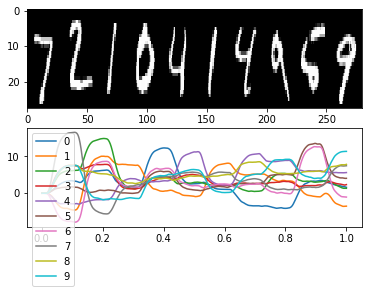

In [10]:
n_plots = 10
plt.figure()

plt.subplot(2, 1, 1)
images = test_images.reshape(-1, 28, 28, 1)[::step]
ni, nj, nc = images[0].shape
allimage = np.zeros((ni, nj * n_plots, nc), dtype=images.dtype)
for i, image in enumerate(images[:n_plots]):
    allimage[:, i * nj : (i + 1) * nj] = image
if allimage.shape[-1] == 1:
    allimage = allimage[:, :, 0]
plt.imshow(allimage, aspect="auto", interpolation="none", cmap="gray")

plt.subplot(2, 1, 2)
plt.plot(sim.trange()[: n_plots * step], sim.data[out_p_filt][: n_plots * step])
plt.legend(["%d" % i for i in range(10)], loc="best")